In [1]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 16.7 MB/s 


In [2]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from art.attacks.evasion import CarliniL2Method, SaliencyMapMethod, ElasticNet
from art.estimators.classification import KerasClassifier

# Set the random seeds. Do not change this!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Define some constants.
NUM_CLASSES = 10
BATCH_SIZE = 32

## Part 1

### You need to complete the following.

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')

# Reshape the data.
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Build a training dataset for the substitute model
# Collect ten images from each dataset class (numbers 0-9)
selected_examples = []
for target_label in range(0, 10):
    count = 0
    for i in range(y_train.shape[0]):
        if y_train[i].tolist().index(1) == target_label:
            count += 1
            selected_examples.append((x_train[i, :, :], y_train[i]))
            if count == 10:
                break

# Convert selected examples to numpy array
# final_train_x =  np.array([selected_examples[i][0] for i in range(len(selected_examples))])
# final_train_y = np.array([selected_examples[i][1] for i in range(len(selected_examples))])
final_train_x = []
final_train_y = []

for example in selected_examples:
  final_train_x.append(example[0])
  final_train_y.append(example[1])
final_train_x = np.array(final_train_x)
final_train_y = np.array(final_train_y)

In [5]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [6]:
# Train a CNN-based substitute model using the newly collected dataset
substitute_model = Sequential()

input_shape = final_train_x[0].shape
print(input_shape)

# Define the intermediate layers.
# GPU
substitute_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
substitute_model.add(MaxPooling2D((2, 2), data_format='channels_first'))
substitute_model.add(Conv2D(64, (3, 3), activation='relu'))
substitute_model.add(MaxPooling2D((2, 2), data_format='channels_first'))
substitute_model.add(Conv2D(64, (3, 3), activation='relu'))

substitute_model.add(Flatten())

substitute_model.add(Dense(64, activation='relu'))
substitute_model.add(Dense(NUM_CLASSES, activation='softmax'))

substitute_model.summary()

# Compile the model
substitute_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

substitute_model = KerasClassifier(model=substitute_model, clip_values=(0,1))

# Fit the model
substitute_model.fit(final_train_x, final_train_y, nb_epochs=30, batch_size=BATCH_SIZE)

(1, 28, 28)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 26, 26)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 13, 13)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 11, 11)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 5, 5)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 3, 3)          36928     
                                                                 
 flatten (Flatten)           (None, 576)    

/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 100 samples
Epoch 1/30
100/100 [==============================] - 9s 89ms/sample - loss: 2.3009 - accuracy: 0.1100
Epoch 2/30
100/100 [==============================] - 0s 272us/sample - loss: 2.2570 - accuracy: 0.3400
Epoch 3/30
100/100 [==============================] - 0s 275us/sample - loss: 2.1986 - accuracy: 0.4500
Epoch 4/30
100/100 [==============================] - 0s 262us/sample - loss: 2.1039 - accuracy: 0.5900
Epoch 5/30
100/100 [==============================] - 0s 233us/sample - loss: 1.9598 - accuracy: 0.5700
Epoch 6/30
100/100 [==============================] - 0s 232us/sample - loss: 1.7647 - accuracy: 0.4900
Epoch 7/30
100/100 [==============================] - 0s 271us/sample - loss: 1.5610 - accuracy: 0.5300
Epoch 8/30
100/100 [==============================] - 0s 229us/sample - loss: 1.2485 - accuracy: 0.6300
Epoch 9/30
100/100 [==============================] - 0s 234us/sample - loss: 1.0554 - accuracy: 0.7100
Epoch 10/30
100/100 [=======================

    Please ONLY use the following attack methods.

In [17]:
import pickle

# Define methods for generating "targetted" adversarial examples
def generate_adv_examples_CarliniL2Method(classifier, x, target_y):
    filename = 'carlinil_adv_examples_gpu.pkl'
    if os.path.exists(filename):
      with open(filename, 'rb') as f:
        return pickle.load(f)
    
    attack = CarliniL2Method(classifier, targeted=True)
    examples = attack.generate(x, target_y)
    
    with open(filename, 'wb') as f:
      pickle.dump(examples, f)
    return examples

def generate_adv_examples_ElasticNet(classifier, x, target_y):
    filename = 'elastic_net_adv_examples_gpu.pkl'
    if os.path.exists(filename):
      with open(filename, 'rb') as f:
        return pickle.load(f)
    
    attack = ElasticNet(classifier, targeted=True)
    examples = attack.generate(x, target_y)
    
    with open(filename, 'wb') as f:
      pickle.dump(examples, f)
    return examples

def generate_adv_examples_SaliencyMapMethod(classifier, x, target_y):
    filename = 'saliency_adv_examples_gpu.pkl'
    if os.path.exists(filename):
      with open(filename, 'rb') as f:
        return pickle.load(f)

    attack = SaliencyMapMethod(classifier)
    examples = attack.generate(x, target_y)
    
    with open(filename, 'wb') as f:
      pickle.dump(examples, f)
    return examples

In [10]:
import os

from google.colab import drive
from shutil import copy

drive.mount('/content/drive')

for filename in ['carlinil_adv_examples_gpu.pkl', 'elastic_net_adv_examples_gpu.pkl', 'saliency_adv_examples_gpu.pkl']:
  # copy(filename, os.path.join('drive/MyDrive/Colab Notebooks', filename))
  src = os.path.join('drive/MyDrive/Colab Notebooks', filename)
  if os.path.exists(src):
    copy(src, filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Build a mapping from the true label to the fake label
# For example, in the mapping below, we want the classifier to predict 0 images as 8.
label_map = {0:8, 1:9, 2:3, 3:5, 4:6, 5:7, 6:4, 7:2, 8:1, 9:0}
for k, v in label_map.items():
    assert(k != v)
assert(len(set(label_map.keys())) == 10)
assert(len(set(label_map.values())) == 10)

# Build target_y
target_y_labels = []
for i in range(final_train_y.shape[0]):
    cur_true_label = final_train_y[i].tolist().index(1)
    target_label = label_map[cur_true_label]
    target_y_labels.append(target_label)
target_y_labels = np.asarray(target_y_labels)
target_y = keras.utils.to_categorical(target_y_labels, NUM_CLASSES)

# Generate 300 adversarial images
carlinil_adv_examples = generate_adv_examples_CarliniL2Method(substitute_model, final_train_x, target_y_labels)
elastic_net_adv_examples = generate_adv_examples_ElasticNet(substitute_model, final_train_x, target_y_labels)
saliency_adv_examples = generate_adv_examples_SaliencyMapMethod(substitute_model, final_train_x, target_y_labels)

print(carlinil_adv_examples.shape, elastic_net_adv_examples.shape, saliency_adv_examples.shape)

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

(100, 1, 28, 28) (100, 1, 28, 28) (100, 1, 28, 28)


In [14]:
def misclassification_ratio(labels, predictions):
  if predictions.shape != (100,):
    predictions = np.argmax(predictions, axis=1)
  return np.count_nonzero(predictions==target_y_labels) / len(target_y_labels)

In [20]:
# Calculate Misclassification Ratio (MR) for CarliniL2Method attack
predictions = substitute_model.predict(carlinil_adv_examples)
carlinil_mr = misclassification_ratio(target_y_labels, predictions)
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

# # Calculate Misclassification Ratio (MR) for ElasticNet attack
predictions = substitute_model.predict(elastic_net_adv_examples)
elastic_net_mr = misclassification_ratio(target_y_labels, predictions)
print('For ElasticNet attack, MR = {}'.format(elastic_net_mr))

# # Calculate Misclassification Ratio (MR) for SaliencyMapMethod attack
predictions = substitute_model.predict(saliency_adv_examples)
saliency_mr = misclassification_ratio(target_y_labels, predictions)
print('For SaliencyMapMethod attack, MR = {}'.format(saliency_mr))

For CarliniL2Method attack, MR = 0.21
For ElasticNet attack, MR = 0.85
For SaliencyMapMethod attack, MR = 1.0


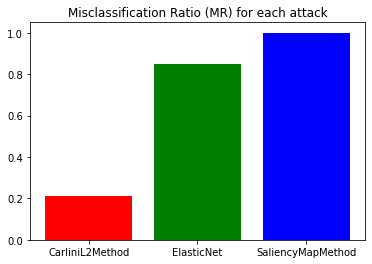

In [23]:
# Make a plot
X = ['CarliniL2Method','ElasticNet', 'SaliencyMapMethod']
Y = [carlinil_mr, elastic_net_mr, saliency_mr]
plt.bar(X, Y, color=['r', 'g', 'b'])
plt.title('Misclassification Ratio (MR) for each attack')
plt.show()
plt.close()

## Part 2

### You need to complete the following.

In [24]:
# Imports
from numpy import linalg as LA

for class_label in range(0, 10):
    print('For images of true class = {}'.format(class_label))
    norms_average = {
        'carlinil': {
            'l0': 0,
            'l2': 0,
            'l_inf': 0,
        },
        'elastic_net': {
            'l0': 0,
            'l2': 0,
            'l_inf': 0,
        },
        'saliency': {
            'l0': 0,
            'l2': 0,
            'l_inf': 0,
        },
    }
    
    ctr = 0
    n = final_train_y.shape[0]
    cur_adv_examples = np.zeros(n)
    for i in range(n):
        cur_true_label = final_train_y[i].tolist().index(1)
        if cur_true_label == class_label:
            ctr += 1
            for attack_method in ['carlinil', 'elastic_net', 'saliency']:
                if attack_method == 'carlinil': cur_adv_examples = carlinil_adv_examples
                elif attack_method == 'elastic_net': cur_adv_examples = elastic_net_adv_examples
                elif attack_method == 'saliency': cur_adv_examples = saliency_adv_examples
                x_diff = (final_train_x[i].squeeze() - cur_adv_examples[i].squeeze()).reshape(-1)
                norms_average[attack_method]['l0'] += LA.norm(x_diff, 0)
                norms_average[attack_method]['l2'] += LA.norm(x_diff, 2)
                norms_average[attack_method]['l_inf'] += LA.norm(x_diff, np.inf)
    
    print('Methods \t L0 \t L2 \t L_inf')
    for attack_method in ['carlinil', 'elastic_net', 'saliency']:
        l0_average = norms_average[attack_method]['l0'] / ctr
        l2_average = norms_average[attack_method]['l2'] / ctr
        linf_average = norms_average[attack_method]['l_inf'] / ctr
        print('{} \t {} \t {} \t {}'.format(attack_method, l0_average, l2_average, linf_average))
    print('\n')

For images of true class = 0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 258.6 	 0.047363905983104616 	 0.015909620955168475
elastic_net 	 301.7 	 2.2371393795663996 	 0.3188082023981028
saliency 	 203.5 	 2.0112981264771332 	 0.9315154637323285


For images of true class = 1
Methods 	 L0 	 L2 	 L_inf
carlinil 	 307.9 	 0.23182663844902995 	 0.09644928324443146
elastic_net 	 203.1 	 1.899119870482749 	 0.42412535991158745
saliency 	 99.6 	 1.7386111742273929 	 0.9300000190734863


For images of true class = 2
Methods 	 L0 	 L2 	 L_inf
carlinil 	 424.9 	 0.24092135161402597 	 0.07783480029999187
elastic_net 	 313.2 	 2.2626752483967976 	 0.4282004784211475
saliency 	 186.4 	 1.5362545734341277 	 0.8184155067720564


For images of true class = 3
Methods 	 L0 	 L2 	 L_inf
carlinil 	 288.2 	 0.15842594222293716 	 0.04581827498200639
elastic_net 	 309.6 	 3.975448261535791 	 0.5492351912165455
saliency 	 170.9 	 2.5138429575748895 	 0.9557545014232034


For images of true class = 4
Methods 	 L0 	 

## Part 3

### You need to complete the following.

In [27]:
!unzip network.zip

Archive:  network.zip
   creating: network/
  inflating: __MACOSX/._network      
  inflating: network/mnist_loader.py  
  inflating: __MACOSX/network/._mnist_loader.py  
  inflating: network/trained_network.pkl  
  inflating: __MACOSX/network/._trained_network.pkl  
   creating: network/__pycache__/
  inflating: network/network.py      
  inflating: __MACOSX/network/._network.py  
  inflating: network/__pycache__/mnist_loader.cpython-310.pyc  
  inflating: network/__pycache__/network.cpython-310.pyc  


In [28]:
# Imports

# Reload the trained model from HW#3 Problem 4
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle

# Load the pre-trained model.
with open('network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    target_net = u.load()

In [29]:
def predict_using_target_net(x, verbose=False):
    x = x.squeeze().reshape(-1, 1)
    outputs = target_net.feedforward(x)
    predictions = np.argmax(outputs)
    if verbose:
        print('Network output: \n' + str(np.round(outputs, 2)) + '\n')
        print('Network prediction: ' + str(predictions) + '\n')
        print('Actual image: ')
    
        # Draw the image
        plt.imshow(x.reshape((28,28)), cmap='Greys')
    return predictions

In [30]:
# Evaluate whether adversarial examples generated with the substitute model will transfer to the target model
for attack_method in ['carlinil', 'elastic_net', 'saliency']:
    if attack_method == 'carlinil': cur_adv_examples = carlinil_adv_examples
    elif attack_method == 'elastic_net': cur_adv_examples = elastic_net_adv_examples
    elif attack_method == 'saliency': cur_adv_examples = saliency_adv_examples
    predictions = [predict_using_target_net(example) for example in cur_adv_examples]
    predictions = np.asarray(predictions)
    mr = misclassification_ratio(target_y_labels, predictions)
    print('For {}, Misclassification Ratio = {}'.format(attack_method, mr))

For carlinil, Misclassification Ratio = 0.04
For elastic_net, Misclassification Ratio = 0.16
For saliency, Misclassification Ratio = 0.06


## Part 4

### You need to complete the following.

In [31]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [32]:
# Re-load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

nb_trains = x_train.shape[0]
nb_tests = x_test.shape[0]

In [ ]:
# ANN model
ann_parameters = {
'hidden_layer_sizes': [(100), (100,100)]
}

ann_clf = GridSearchCV(None)
ann_clf.fit(None)
print(None)

In [ ]:
# SVM model
svm_parameters = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

svm_clf = GridSearchCV(None)
svm_clf.fit(None)
print(None)

In [ ]:
# Logistic Regression model
lr_parameters = {
    'multi_class': ['auto'],
    'penalty' : ['l1', 'l2'],
    'C': [1, 10],
}

lr_clf = GridSearchCV(None)
lr_clf.fit(None)
print(None)

In [ ]:
# kNN
knn_parameters = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance']
}
knn_clf = GridSearchCV(None)
knn_clf.fit(None)
print(None)

In [ ]:
# Naive Bayes
naive_bayes_parameters = {
    'var_smoothing': [1e-3, 1e-2, 1e-1]
}
naive_bayes_clf = None
naive_bayes_clf.fit(None)
print(None)

In [ ]:
# Voting classifiers
voting_clf = VotingClassifier(estimators=[
                                ('naive_bayes', GaussianNB()),
                                ('ann', MLPClassifier()),
                                ('lr', LogisticRegression()),
                               ], voting='soft')

params = {
          'naive_bayes__var_smoothing': [1e-3, 1e-2, 1e-1],
          'lr__C': [1, 10],
          'ann__hidden_layer_sizes': [(100), (100,100)]}

voting_clf = GridSearchCV(None)
voting_clf.fit(None)
print(None)

In [ ]:
classifier_names = ['ANN', 'SVM', 'Logistic Regression', 'kNN', 'Naive Bayes', 'Voting classifiers']
classifiers = [ann_clf, svm_clf, lr_clf, knn_clf, naive_bayes_clf, voting_clf]
print('Methods \t Test Acc \t Carlinil MR \t ElasticNet MR \t Saliency MR')
for i in range(len(classifiers)):
    test_acc = None
    carlinil_acc = None
    elasticnet_acc = None
    saliency_acc = None
    print('{} \t {} \t {} \t {} \t {}'.format(classifier_names[i], str(test_acc), str(carlinil_acc), str(elasticnet_acc), str(saliency_acc)))